In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider, IntSlider

# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

D:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Mnist 

In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


# Set VAE

In [4]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [5]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


Sampling  function

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [8]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [9]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

Loss function

In [10]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [11]:
VAE.compile(loss=vae_loss, optimizer=Adam(), metrics=['accuracy'])

In [ ]:
VAE.fit(x_train, x_train, batch_size=32, epochs=70)

# 使用助教訓練後的權重

In [12]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

# Visualization Encoder

Encoder model

In [13]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [14]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 26886 圖的 latent 表示為 [[-1.9299327  1.248352 ]]


In [15]:
x_test.shape[0]

10000

抽出3000筆 testing data 繪圖

In [16]:
indices = np.random.randint(10000, size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])
VAE_latents.shape

(3000, 2)

繪出平均散佈圖

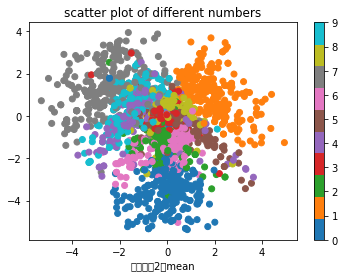

In [17]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab10')
plt.colorbar()
plt.title('scatter plot of different numbers')
plt.xlabel("各數字的2維mean")
plt.show()

# Visualization Decoder

Encoder model

In [18]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [19]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

使用Decoder繪製還原後的數字

In [20]:
n =15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

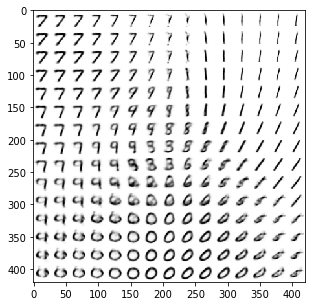

In [21]:
plt.figure(figsize=(5, 5))
plt.imshow(VAE_figure, cmap='Greys')
plt.show()

# 中間圖形顯示變換

In [22]:
#字型
font = {'family' : 'DFKai-SB', 'weight' : 'bold', 'size'  : '16'}
plt.rc('font', **font) 
plt.rc('axes',unicode_minus=False)

# 建立數字0 ~ 9 的index
num_index = [[] for i in range(0, 10)]
for i in range(0, 60000):
    num_index[y_train0[i]] += [i]
idx_1 = 0
idx_2 = 9

#
def inBetween(t, NUM_1, NUM_2):
    global idx_1
    global idx_2
    
    ## 在前後數字重新選取時，才重新抽樣
    if(idx_1 not in num_index[NUM_1]):
        idx_1 = np.random.choice(num_index[NUM_1])
    if(idx_2 not in num_index[NUM_2]):
        idx_2 = np.random.choice(num_index[NUM_2])
        
    #取 data
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]
    
    # 使用Encoder壓縮成 2 維 mean
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    
    # 用mean當座標繪製散布圖
    plt.figure(figsize=(10, 7))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1], label='一開始的數字')
    ax1.scatter(mu_1[0], mu_1[1], label='最後的數字')
    ax1.scatter(mu_t[0], mu_t[1], label='中間變化mean')
    ax1.annotate(NUM_1, (mu_0[0], mu_0[1]))
    ax1.annotate(NUM_2, (mu_1[0], mu_1[1]))
    ax1.annotate('(' + str(mu_t[0]) + ', ' + str(mu_t[1]) + ')', (mu_t[0], mu_t[1]))
    
    # 以 NUM_1 和 NUM_2 的 mean為端點的斜直線
    ax1.legend()
    ax1.plot([mu_0[0], mu_1[0]], [mu_0[1], mu_1[1]], ls='-.', alpha=0.7)
    
    #  NUM_1 image
    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('一開始的數字')
    
    #  middle image with different propotion of value t 
    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title('中間變化')
    
    #  NUM_2 image
    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('最後的數字')

In [23]:
interact(inBetween, NUM_1=IntSlider(value=0, min=0, max=9),
                    NUM_2=IntSlider(value=0, min=0, max=9),
                    t=FloatSlider(value=0.5, min=0, max=1.0, step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), IntSlider(value=0, descript…

<function __main__.inBetween(t, NUM_1, NUM_2)>

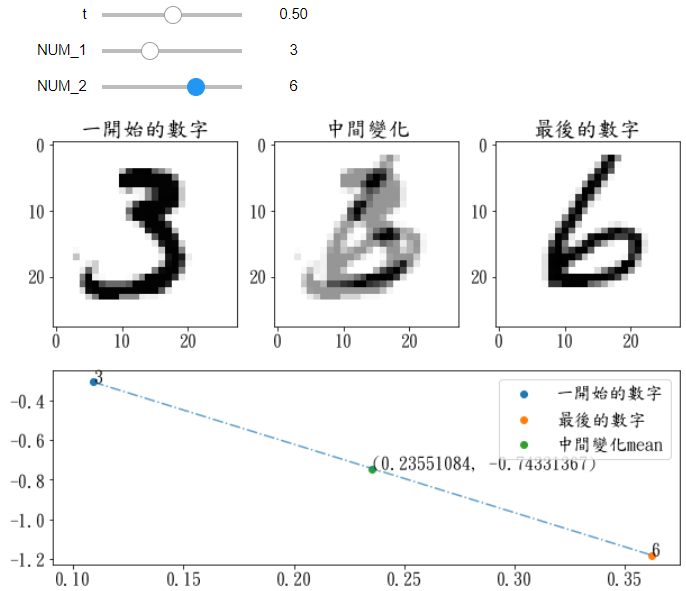

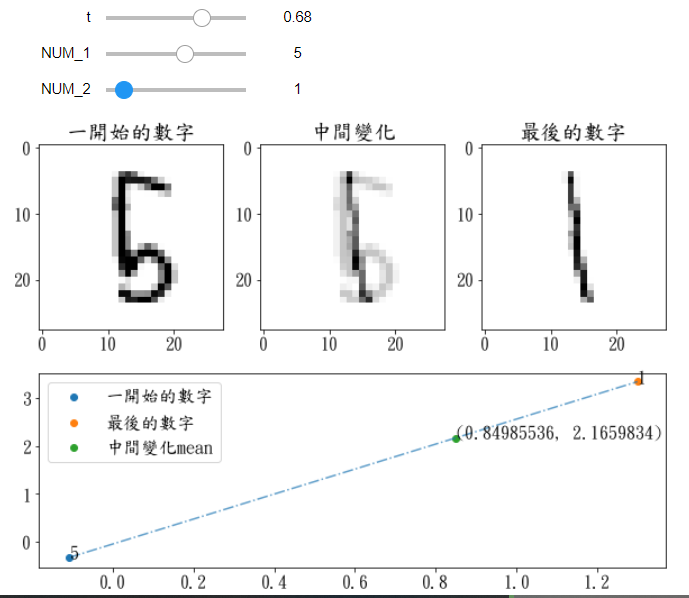